In [1]:
import sys
sys.path.append("..")
import time
from utils import eval_onnx, load_onnx, load_yaml, preprocess, postprocess,invert_affine, read_imgs

/home/mazheng/miniconda3/envs/eff/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [3]:
ort_session = load_onnx('/home/mazheng/waste-detection/Yet-Another-EfficientDet-Pytorch/onnx_inference/model/v1/model.onnx')

In [4]:
project_name = "0509split"
onnx_path = '/home/mazheng/waste-detection/Yet-Another-EfficientDet-Pytorch/inference_tool/weights/efficientdet-d2.onnx'
# onnx_path = "efficientdet-d2.onnx"
compound_coef = 2
threshold = 0.2
iou_threshold = 0.2

In [5]:
from pathlib import Path
path = Path.cwd().parents[1]
img_path = path / 'datasets/{}/val'.format(project_name)
ann_json = path / 'datasets/{}/annotations/instances_val.json'.format(project_name)
yaml_path = path / 'projects/{}.yml'.format(project_name)

project_params = load_yaml(str(yaml_path))
obj_list = project_params['obj_list']

In [6]:
from torch.backends import cudnn
import torch
import numpy as np


In [7]:
print(torch.__version__) 

1.4.0


In [8]:
img_name = "DLLJ1796.jpg"
img_path = str(img_path/img_name)

In [9]:
def nms_np(boxes, scores,overlap_threshold=0.5, min_mode=False):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        keep.append(order[0])
        xx1 = np.maximum(x1[order[0]], x1[order[1:]])
        yy1 = np.maximum(y1[order[0]], y1[order[1:]])
        xx2 = np.minimum(x2[order[0]], x2[order[1:]])
        yy2 = np.minimum(y2[order[0]], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        if min_mode:
            ovr = inter / np.minimum(areas[order[0]], areas[order[1:]])
        else:
            ovr = inter / (areas[order[0]] + areas[order[1:]] - inter)

        inds = np.where(ovr <= overlap_threshold)[0]
        order = order[inds + 1]
    return keep

def batch_nms_np(boxes, scores, idxs, iou_threshold):
    if len(boxes) == 0:
        return np.array([])
    # strategy: in order to perform NMS independently per class.
    # we add an offset to all the boxes. The offset is dependent
    # only on the class idx, and is large enough so that boxes
    # from different classes do not overlap
    max_coordinate = boxes.max()
    offsets = idxs * (max_coordinate + 1)
    boxes_for_nms = boxes + offsets[:, None]
    keep = nms_np(boxes_for_nms, scores, iou_threshold)
    return keep


In [43]:
from torchvision.ops.boxes import batched_nms

In [88]:
def postprocess_np(
    x,
    transformed_anchors,
    classification,
    threshold,
    iou_threshold,
):
    # transformed_anchors = torch.from_numpy(transformed_anchors)
    # classification = torch.from_numpy(classification)
    scores_ = torch.max(torch.from_numpy(classification), axis=2, keepdims=True)[0]
    scores = np.amax(classification, axis=2, keepdims=True)
    # print(scores_.shape,scores.shape)
    # print(scores_.numpy() - scores)
    scores_over_thresh = (scores > threshold)[:, :, 0]
    out = []
    for i in range(x.shape[0]):
        if scores_over_thresh[i].sum() == 0:
            # print(scores_over_thresh[i].sum())
            out.append(
                {
                    "rois": np.array(()),
                    "class_ids": np.array(()),
                    "scores": np.array(()),
                }
            )
            continue
        classification_ = torch.from_numpy(classification)
        classification_per_ = classification_[i, scores_over_thresh[i, :], ...].permute(
                    1, 0
        )


        classification_per = np.moveaxis(classification[i, scores_over_thresh[i, :], ...],0,1)
        # print(classification_per_.numpy() - classification_per)
        # print(classification_per_.shape , classification_per.shape)

        transformed_anchors_per = transformed_anchors[i, scores_over_thresh[i, :], ...]
        scores_per = scores[i, scores_over_thresh[i, :], ...]
        t1 = time.time()
        scores, classes = classification_per_.max(dim=0)

        # print(classification_per_.max(dim=0)[1])
        t2 = time.time()
        classes_ = np.argmax(classification_per, axis=0)
        # Same as np.amax(x, axis=-1, keepdims=True)
        scores_ =  np.take_along_axis(classification_per, np.expand_dims(classes_, axis=0),axis = 0).squeeze(axis=0)

        t3 = time.time()
        # print(classes_,classification_per[4])
        # print(scores_,scores)
        # scores_, classes_ = np.amax(classification_per, axis=0)
        anchors_nms_idx = np.array(batch_nms_np(
            transformed_anchors_per,
            scores_per[:, 0],
            classes_,
            iou_threshold=iou_threshold,
        ))
        t4 = time.time()
        anchors_nms_idx = batched_nms(
            torch.from_numpy(transformed_anchors_per),
            torch.from_numpy(scores_per[:, 0]),
            classes,
            iou_threshold=iou_threshold,
        )
        t5 = time.time()
        print(t2-t1,t3-t2)
        print(t4-t3,t5-t4)

        if anchors_nms_idx.shape[0] != 0:
            classes_ = classes_[anchors_nms_idx]
            scores_ = scores_[anchors_nms_idx]
            boxes_ = transformed_anchors_per[anchors_nms_idx, :]

            out.append(
                {
                    "rois": boxes_,
                    "class_ids": classes_,
                    "scores": scores_,
                }
            )
        else:
            out.append(
                {
                    "rois": np.array(()),
                    "class_ids": np.array(()),
                    "scores": np.array(()),
                }
            )

    return out

In [12]:
# cudnn.fastest = True
print_fps = True
input_sizes=[512, 640, 768, 896, 1024, 1280, 1280, 1536]
# cudnn.benchmark = True
input_size = input_sizes[compound_coef]

img =read_imgs(str(img_path))
ori_imgs, framed_imgs, framed_metas = preprocess(
    img,
    max_size=input_size,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

x = np.stack(framed_imgs, 0)
x = np.moveaxis(x, [0, 3, 1, 2], [0, 1, 2, 3])

ort_inputs = {ort_session.get_inputs()[0].name: x}
if print_fps:
    print("model inferring and postprocessing...")
    t1 = time.time()
# _, _, _, _, _, regression, classification, anchors = ort_session.run(
#     None, ort_inputs
# )
# for i in range(10):
classification, anchors = ort_session.run(None, ort_inputs)
if print_fps:
    t2 = time.time()
    tact_time = (t2 - t1)
    print(f"{tact_time} seconds, {1 / tact_time} FPS, @batch_size 1")



model inferring and postprocessing...
3.6197221279144287 seconds, 0.2762643000379062 FPS, @batch_size 1


In [90]:
out = postprocess(
    x,
    anchors,
    classification,
    threshold,
    iou_threshold,
)

out_ = postprocess_np(
    x,
    anchors,
    classification,
    threshold,
    iou_threshold,
)

5.030632019042969e-05 0.00010800361633300781
0.0001933574676513672 0.0004239082336425781


In [85]:
out_ = invert_affine(framed_metas, out_)
out = invert_affine(framed_metas, out)
# t2 = time.time()
# tact_time = (t2 - t1)
# print(f"{tact_time} seconds, {1 / tact_time} FPS, @batch_size 1")

In [86]:
print(out_,out)

[{'rois': array([[131.14008, 480.1472 , 374.68195, 715.7616 ]], dtype=float32), 'class_ids': array([4]), 'scores': array([0.8990546], dtype=float32)}] [{'rois': array([[131.14008, 480.1472 , 374.68195, 715.7616 ]], dtype=float32), 'class_ids': array([4]), 'scores': array([0.8990546], dtype=float32)}]


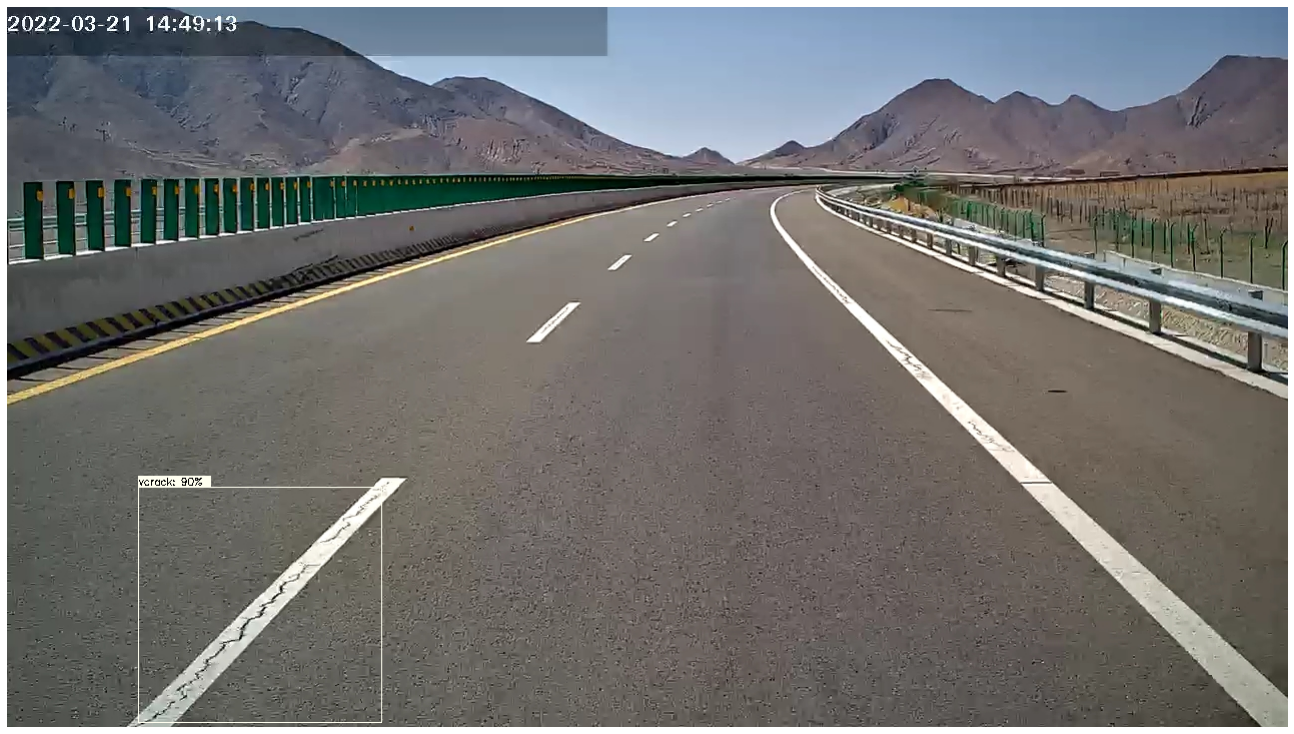

In [87]:
from utils import display_bbox
display_bbox(
    out_,
    ori_imgs,
    obj_list,
)

In [12]:
img_name = "DLLJ1796.jpg"
# img_path = str(img_path/img_name)
# for i in range(10):
out, ori_imgs = eval_onnx(
            ort_session,
            2,
            str(img_path),
            threshold,
            iou_threshold,
            use_float16=False,
            input_sizes=[512, 640, 768, 896, 1024, 1280, 1280, 1536],
            print_fps=True,
        )

model inferring and postprocessing...
0.11185026168823242 seconds, 8.940524455699224 FPS, @batch_size 1
